### Cài đặt thuật toán Merge Sort xử lý song song

Trong notebook này, chúng ta sẽ cài đặt thuật toán sắp xếp trộn với khả năng xử lý song song nhờ vào khả năng tính toán song song trên nhiều tiến trình của CPU. Đồng thời ta cũng so sánh nó với thuật toán sắp xếp trộn cổ điển về thời gian thực thi và đưa ra những nhận xét.

Trước hết ta cần import một số thư viện cần thiết:

In [8]:
import multiprocessing
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt

Sau đó ta tiến hành cài đặc thuật toán merge sort cổ điển và merge sort xử lý song song:

In [9]:
import multiprocessing

def merge(left, right):
    """
    Hợp nhất hai mảng con đã sắp xếp thành một mảng con lớn đã sắp xếp.

    Args:
        left (list): Mảng con trái.
        right (list): Mảng con phải.

    Returns:
        list: Mảng đã sắp xếp chứa tất cả các phần tử từ mảng con trái và phải.
    """
    result = []
    i = j = 0

    while i < len(left) and j < len(right):
        if left[i] < right[j]:
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            j += 1

    result.extend(left[i:])
    result.extend(right[j:])
    return result

def regular_mergesort(arr):
    """
    Sắp xếp một mảng bằng thuật toán mergesort.

    Args:
        arr (list): Mảng cần sắp xếp.

    Returns:
        list: Mảng đã sắp xếp.
    """
    if len(arr) <= 1:
        return arr

    mid = len(arr) // 2
    left = arr[:mid]
    right = arr[mid:]

    left = regular_mergesort(left)
    right = regular_mergesort(right)

    return merge(left, right)


def parallel_mergesort(arr):
    """
    Sắp xếp một mảng bằng thuật toán mergesort song song sử dụng multiprocessing.

    Args:
        arr (list): Mảng cần sắp xếp.

    Returns:
        list: Mảng đã sắp xếp.
    """
    num_processes = multiprocessing.cpu_count()

    # Chỉ sử dụng số tiến trình bằng số phần tử nếu dãy quá nhỏ
    if len(arr) < num_processes:
        num_processes = len(arr)  

    # Chia dãy thành các phần nhỏ
    chunk_size = len(arr) // num_processes
    chunks = [arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size)]

    # Sắp xếp các phần nhỏ bằng các tiến trình riêng biệt
    with multiprocessing.Pool(num_processes) as pool:
        sorted_chunks = pool.map(regular_mergesort, chunks)

    # Hợp nhất các phần nhỏ đã sắp xếp để có mảng đã sắp xếp hoàn chỉnh
    sorted_arr = sorted_chunks[0]
    for i in range(1, len(sorted_chunks)):
        sorted_arr = merge(sorted_arr, sorted_chunks[i])

    return sorted_arr


Ta cần cài đặc hàm kiểm tra xem 2 mảng có bằng nhau không nhằm kiểm tra tính đúng đắn của 2 thuật toán đã cài đặt.

In [10]:
def compare_arr(arr1, arr2):
    if len(arr1) != len(arr2):
        return False
    
    for i in range(len(arr1)):
        if arr1[i] != arr2[i]:
            return False
        
    return True

Sau đó ta thiết kế hàm để tiến hành chạy thử nghiệm 2 hàm trên trên những mảng có kích thước khác nhau và ghi nhận lại kết quả.

In [11]:
def run_test(arr_size_min, arr_size_max, step, num_iterations=5):
    """
    Tạo các mảng với kích thước khác nhau và ghi nhận thời gian thực thi của 
    2 hàm tương ứng với 2 thuật toán merge sort cổ điển và merge sort xử lý
    song song

    Args:
        arr_size_min: Kích thước mảng nhỏ nhất.
        arr_size_max: Kích thước mảng lớn nhất.
        step: Bước nhảy.
        num_iterations: Số lần lặp lại để tính trung bình cộng.

    Returns:
        (list): mảng chứa thời gian thực thi của hàm regular_mergesort.
        (list): mảng chứa thời gian thực thi của hàm parallel_mergesort.
    """
    result1 = []
    result2 = []
    test_id = 1
    for arr_size in range(arr_size_min, arr_size_max + 1, step):
        print(f"# Test {test_id} - kích thước mảng: {arr_size} - thời gian thực thi trung bình:")
        avg_time1 = 0
        avg_time2 = 0
        for _ in range(num_iterations):
            arr = [random.random() for _ in range(arr_size)]

            # Ghi nhận thời gian thực thi của hàm regular_mergesort
            start_time = time.time()
            regular_mergesort(arr)
            avg_time1 += time.time() - start_time

            # Ghi nhận thời gian thực thi của hàm parallel_mergesort
            start_time = time.time()
            parallel_mergesort(arr)
            avg_time2 += time.time() - start_time

        # Lưu vào mảng kết quả
        result1.append(avg_time1/num_iterations)
        result2.append(avg_time2/num_iterations)

        # In ra màn hình thời gian thi của 2 hàm
        print(f"regular_mergesort:  {avg_time1/num_iterations:.4f}")
        print(f"parallel_mergesort: {avg_time2/num_iterations:.4f}")
        print()
        test_id += 1

    return result1, result2

Trước khi đánh giá thời gian chạy, ta cần kiểm tra xem 2 hàm có sắp xếp đúng không.

In [12]:
# Tạo mảng các giá trị ngẫu nhiên với 1 triệu phần tử
arr = [random.random() for _ in range(1000000)]
# Sử dụng hàm sorted của python để sắp xếp mẫu
sorted_arr = sorted(arr)
# So sánh kết quả của 2 hàm đối với kết quả của hàm sorted từ python.
assert compare_arr(sorted_arr, regular_mergesort(arr))
assert compare_arr(sorted_arr, parallel_mergesort(arr))

Sau khi chắc chắn rằng 2 hàm sắp xếp đúng, ta tiến hành chạy thử 2 hàm bằng hàm `run_test()`

In [13]:
arr_size_min = 100_000
arr_size_max = 1_000_000
step = 100_000
result1, result2 = run_test(arr_size_min, arr_size_max, step)

# Test 1 - kích thước mảng: 100000 - thời gian thực thi trung bình:
regular_mergesort:  0.1727
parallel_mergesort: 0.2842

# Test 2 - kích thước mảng: 200000 - thời gian thực thi trung bình:
regular_mergesort:  0.3942
parallel_mergesort: 0.4234

# Test 3 - kích thước mảng: 300000 - thời gian thực thi trung bình:
regular_mergesort:  0.6394
parallel_mergesort: 0.5363

# Test 4 - kích thước mảng: 400000 - thời gian thực thi trung bình:
regular_mergesort:  0.8733
parallel_mergesort: 0.6220

# Test 5 - kích thước mảng: 500000 - thời gian thực thi trung bình:
regular_mergesort:  1.1975
parallel_mergesort: 0.7762

# Test 6 - kích thước mảng: 600000 - thời gian thực thi trung bình:
regular_mergesort:  1.4677
parallel_mergesort: 0.8971

# Test 7 - kích thước mảng: 700000 - thời gian thực thi trung bình:
regular_mergesort:  1.7225
parallel_mergesort: 0.9739

# Test 8 - kích thước mảng: 800000 - thời gian thực thi trung bình:
regular_mergesort:  1.9764
parallel_mergesort: 1.0419

# Test 9 - kích 

Cuối cùng ta vẽ biểu đồ thể hiện thời gian chạy của 2 hàm tương ứng với 2 thuật toán sắp xếp trên những mảng có kích thước tăng dần.

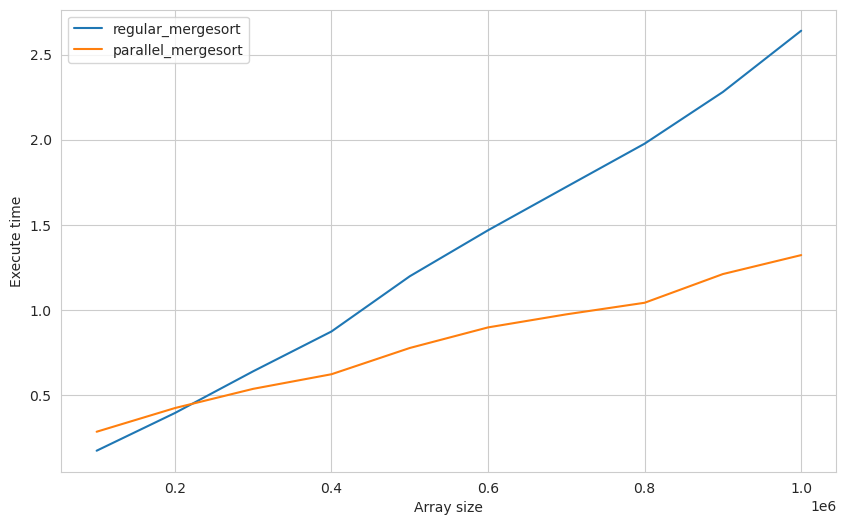

In [14]:
sns.set_style("whitegrid") 
plt.figure(figsize=(10, 6))  

sns.lineplot(x=range(arr_size_min, arr_size_max + 1, step), y=result1, label="regular_mergesort")
sns.lineplot(x=range(arr_size_min, arr_size_max + 1, step), y=result2, label="parallel_mergesort")

plt.xlabel("Array size")
plt.ylabel("Execute time")
plt.legend()
plt.show()

**Nhận xét**:
- Đối với những mảng có kích thước nhỏ vào khoảng dưới 250.000 phần tử, thuật toán sắp xếp trộn cổ điển cho thời gian thực thi thấp hơn so với sắp xếp trộn xử lý song song.

- Tuy nhiên khi kích thước mảng càng tăng cao, thuật toán sắp xếp trộn xử lý song song cho hiệu suất tốt hơn rõ rệt do tận dụng được khả năng tính toán song song của máy tính.

- Việc lựa chọn giữa sắp xếp trộn cổ điển và sắp xếp trộn xử lý song song phụ thuộc vào kích thước dữ liệu và tài nguyên có sẵn. Nếu bạn có ít tài nguyên tính toán và dữ liệu nhỏ, sắp xếp trộn cổ điển có thể là lựa chọn tốt hơn. Tuy nhiên, khi bạn có nhiều tài nguyên và dữ liệu lớn, sắp xếp trộn xử lý song song sẽ làm tăng hiệu suất.